In [2]:
# --- Core imports
import pandas as pd

# --- Your project modules
from src.data import get_price_data
from src.strategies import signal_sma_crossover, signal_mean_reversion, align_next_bar
from src.engine import run_backtest
from src.metrics import summarize_backtest_performance, extract_trades, trade_stats, drawdown_series

# --- Plots
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.expand_frame_repr", False)

In [3]:
TICKERS = ["AAPL", "MSFT"] 
START = "2022-01-01"
END   = "2022-12-31"

# Strategy params
SMA_FAST = 20
SMA_SLOW = 50

MR_LOOKBACK = 20
MR_ENTRY = 1.0
MR_EXIT  = 0.2

INITIAL_CASH = 100_000
FEE_BPS = 1.0
SLIP_BPS = 0.0


In [4]:
df = get_price_data(TICKERS, START, END)

# Convenience helpers
def get_cols(symbol: str):
    return df[(symbol, "Close")], (df[(symbol, "Open")] if ("Open" in df[symbol].columns) else None)

df.head(3)

[*********************100%***********************]  2 of 2 completed


AAPL                                                                  MSFT                                                          
                  Open        High         Low       Close   Adj Close    Volume        Open        High         Low       Close   Adj Close    Volume
Date                                                                                                                                                  
2022-07-05  137.770004  141.610001  136.929993  141.559998  139.166809  73353800  256.160004  262.980011  254.740005  262.850006  255.926727  22941000
2022-07-06  141.350006  144.119995  141.080002  142.919998  140.503830  74064300  263.750000  267.989990  262.399994  266.209991  259.198273  23824400
2022-07-06  141.350006  144.119995  141.080002  142.919998  140.503845  74064300  263.750000  267.989990  262.399994  266.209991  259.198242  23824400

In [5]:
# Pick one to explore first
SYM = "AAPL"
close, open_ = get_cols(SYM)

sig_sma_raw = signal_sma_crossover(close, fast=SMA_FAST, slow=SMA_SLOW)
sig_mr_raw  = signal_mean_reversion(close, lookback=MR_LOOKBACK, entry=MR_ENTRY, exit=MR_EXIT)

# Align to trade next bar (no look-ahead)
sig_sma = align_next_bar(sig_sma_raw)
sig_mr  = align_next_bar(sig_mr_raw)

sig_sma.head(10), sig_mr.head(10)

(Date
 2022-07-05    0
 2022-07-06    0
 2022-07-06    0
 2022-07-07    0
 2022-07-07    0
 2022-07-08    0
 2022-07-08    0
 2022-07-11    0
 2022-07-11    0
 2022-07-12    0
 dtype: int64,
 Date
 2022-07-05    0
 2022-07-06    0
 2022-07-06    0
 2022-07-07    0
 2022-07-07    0
 2022-07-08    0
 2022-07-08    0
 2022-07-11    0
 2022-07-11    0
 2022-07-12    0
 dtype: int64)

In [6]:
bt_sma = run_backtest(close, sig_sma, open_=open_, initial_cash=INITIAL_CASH, fee_bps=FEE_BPS, slippage_bps=SLIP_BPS)
bt_mr  = run_backtest(close, sig_mr,  open_=open_, initial_cash=INITIAL_CASH, fee_bps=FEE_BPS, slippage_bps=SLIP_BPS)

sum_sma = summarize_backtest_performance(bt_sma["equity"])
sum_mr  = summarize_backtest_performance(bt_mr["equity"])

print("Summary (SMA):", sum_sma)
print("Summary (MR): ", sum_mr)

tr_sma = extract_trades(bt_sma)
tr_mr  = extract_trades(bt_mr)
print("\nTrades (SMA):")
display(tr_sma)
print("\nTrade stats (SMA):", trade_stats(tr_sma))

print("\nTrades (MR):")
display(tr_mr)
print("\nTrade stats (MR):", trade_stats(tr_mr))

Summary (SMA): {'total_return': -0.0336333831440333, 'CAGR': -0.06779437692961254, 'vol_ann': 0.15735445917460886, 'sharpe': -0.1424945632606723, 'sortino': -0.11753942544570195, 'max_drawdown': -0.13400545550187892, 'longest_drawdown_days': 86}
Summary (MR):  {'total_return': -0.029037162851621057, 'CAGR': -0.05867372140443117, 'vol_ann': 0.19116883340031895, 'sharpe': -0.06072233748595975, 'sortino': -0.06291252715185922, 'max_drawdown': -0.1621651785638888, 'longest_drawdown_days': 149}

Trades (SMA):


,entry_date,entry_px,exit_date,exit_px,shares,pnl,return
0,2022-10-27,148.070007,2022-11-11,148.970001,675.288688,607.755698,0.006078
1,2022-11-22,148.130005,2022-12-09,142.339996,678.982217,-3931.312840,-0.039087



Trade stats (SMA): {'num_trades': 2, 'win_rate': 0.5, 'avg_win': 607.7556976973113, 'avg_loss': -3931.3128397832543, 'profit_factor': 0.1545935728001791}

Trades (MR):


,entry_date,entry_px,exit_date,exit_px,shares,pnl,return
0,2022-08-23,167.080002,2022-09-12,159.589996,598.455829,-4482.437446,-0.044829
1,2022-09-13,154.789993,2022-10-06,145.809998,616.890420,-5539.673335,-0.058014
2,2022-10-07,140.419998,2022-10-17,145.490005,640.441560,3247.043399,0.036106
3,2022-11-02,142.059998,2022-11-30,148.210007,655.773715,4033.014351,0.043292
4,2022-12-06,142.190002,2022-12-12,149.500000,683.401002,4995.659659,0.051410



Trade stats (MR): {'num_trades': 5, 'win_rate': 0.6, 'avg_win': 4091.9058029969983, 'avg_loss': -5011.055390615322, 'profit_factor': 1.2248634720722598}


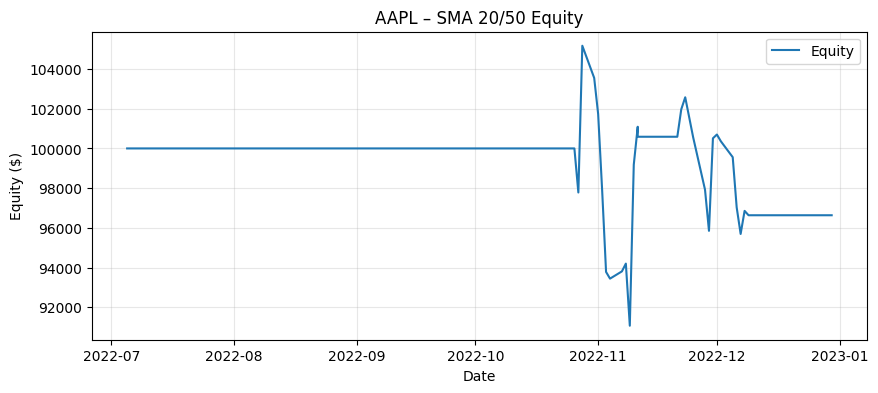

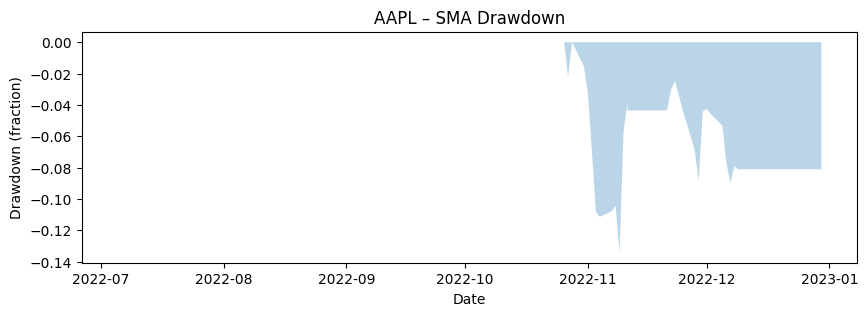

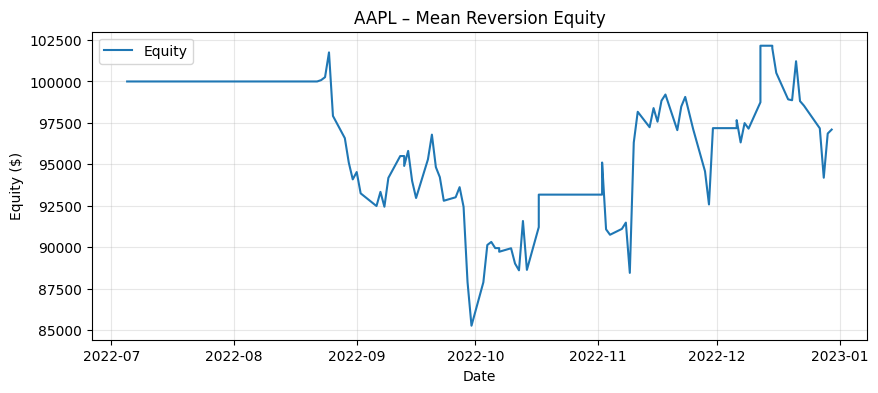

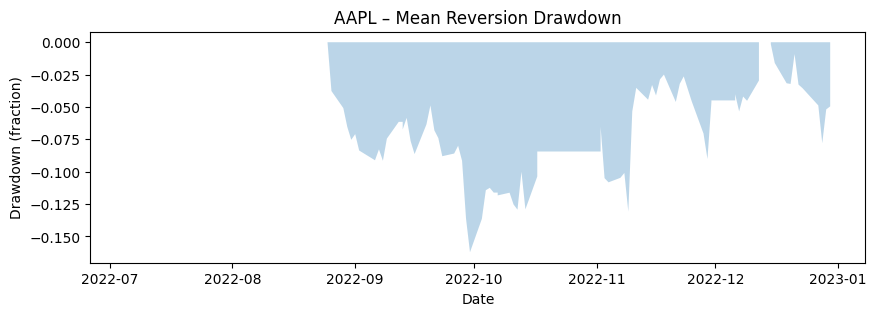

In [7]:
def plot_equity(equity, title="Equity Curve"):
    plt.figure(figsize=(10,4))
    plt.plot(equity.index, equity.values, label="Equity")
    plt.title(title); plt.ylabel("Equity ($)"); plt.xlabel("Date")
    plt.grid(alpha=0.3); plt.legend(); plt.show()

def plot_drawdown(equity, title="Drawdown"):
    dd = drawdown_series(equity)
    plt.figure(figsize=(10,3))
    plt.fill_between(dd.index, dd.values, 0, alpha=0.3)
    plt.title(title); plt.ylabel("Drawdown (fraction)"); plt.xlabel("Date")
    plt.show()

plot_equity(bt_sma["equity"], title=f"{SYM} – SMA {SMA_FAST}/{SMA_SLOW} Equity")
plot_drawdown(bt_sma["equity"], title=f"{SYM} – SMA Drawdown")

plot_equity(bt_mr["equity"],  title=f"{SYM} – Mean Reversion Equity")
plot_drawdown(bt_mr["equity"], title=f"{SYM} – Mean Reversion Drawdown")

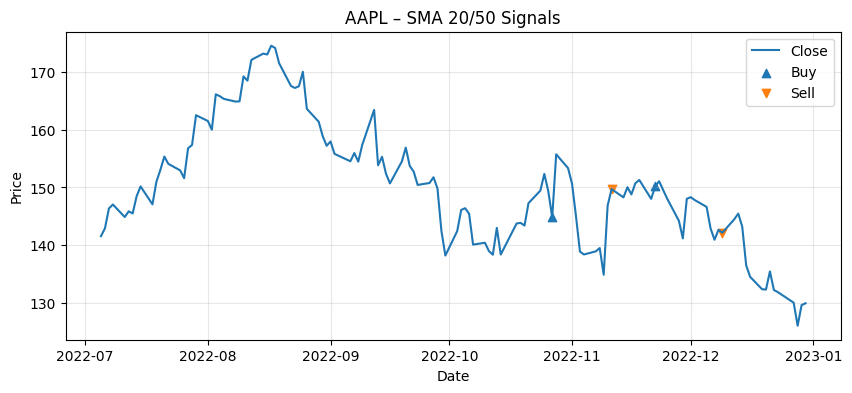

In [14]:
def _to_series_1d(x):
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1:
            x = x.iloc[:, 0]
        else:
            x = x.squeeze()
    return pd.Series(x)

def _clean_series(s: pd.Series) -> pd.Series:
    s = _to_series_1d(s).copy()
    # Coerce to datetime index if possible
    if not isinstance(s.index, pd.DatetimeIndex):
        try:
            s.index = pd.to_datetime(s.index)
        except Exception:
            pass
    # Drop duplicate timestamps (keep last) and sort
    s = s[~s.index.duplicated(keep="last")].sort_index()
    return s

def plot_signals(close, signal, title="Price + Signals"):
    close = _clean_series(close).astype(float)
    sig   = _clean_series(signal)

    # Align signal to close dates; missing -> 0
    s = sig.reindex(close.index, fill_value=0).astype(int)

    # flips: buy on 0->1, sell on 1->0
    d = s.diff().fillna(0)
    buys_idx  = close.index[d > 0]
    sells_idx = close.index[d < 0]

    y_buys  = close.reindex(buys_idx)
    y_sells = close.reindex(sells_idx)

    plt.figure(figsize=(10,4))
    plt.plot(close.index, close.values, label="Close")
    if len(buys_idx):
        plt.scatter(buys_idx,  y_buys.values,  marker="^", label="Buy")
    if len(sells_idx):
        plt.scatter(sells_idx, y_sells.values, marker="v", label="Sell")
    plt.title(title); plt.xlabel("Date"); plt.ylabel("Price")
    plt.grid(alpha=0.3); plt.legend(); plt.show()

# Call it
plot_signals(close, sig_sma, title=f"{SYM} – SMA {SMA_FAST}/{SMA_SLOW} Signals")

In [15]:
rows = []
for sym in TICKERS:
    c, o = get_cols(sym)
    s = align_next_bar(signal_sma_crossover(c, fast=SMA_FAST, slow=SMA_SLOW))
    bt = run_backtest(c, s, open_=o, initial_cash=INITIAL_CASH, fee_bps=FEE_BPS, slippage_bps=SLIP_BPS)
    summ = summarize_backtest_performance(bt["equity"])
    rows.append({"symbol": sym, **summ})

pd.DataFrame(rows)

,symbol,total_return,CAGR,vol_ann,sharpe,sortino,max_drawdown,longest_drawdown_days
0,AAPL,-0.033633,-0.067794,0.157354,-0.142495,-0.117539,-0.134005,86
1,MSFT,-0.026846,-0.054309,0.109101,-0.197528,-0.141981,-0.073983,42


Assumptions: daily data, next-bar execution (Open if available), long/flat, fees in bps, no leverage/shorting, float shares.

Limitations: no intraday fills, simple slippage model, no borrow costs, slow signals may underperform in choppy markets.

Next steps: parameter grid search, portfolio of multiple tickers, risk targeting (vol parity), walk-forward split.